In [8]:
from os.path import expanduser, join


import sys

import time

from nnmnkwii.datasets import FileDataSource, FileSourceDataset
from nnmnkwii.datasets import PaddedFileSourceDataset, MemoryCacheDataset  # これはなに？
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames
from nnmnkwii.preprocessing import minmax, meanvar, minmax_scale, scale
from nnmnkwii import paramgen
from nnmnkwii.io import hts
from nnmnkwii.frontend import merlin as fe
from nnmnkwii.postfilters import merlin_post_filter

from os.path import join, expanduser, basename, splitext, basename, exists
import os
from glob import glob
import numpy as np
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
import librosa
import librosa.display
import IPython
from IPython.display import Audio

import matplotlib.pyplot as plt

In [9]:
from torch.utils import data as data_utils


import torch
from torch import nn
from torch.autograd import Variable
from tqdm import tnrange, tqdm
from torch import optim
import torch.nn.functional as F

In [10]:

mgc_dim = 180  # メルケプストラム次数　？？
lf0_dim = 3  # 対数fo　？？ なんで次元が３？
vuv_dim = 1  # 無声or 有声フラグ　？？
bap_dim = 15  # 発話ごと非周期成分　？？

duration_linguistic_dim = 438  # question_jp.hed で、ラベルに対する言語特徴量をルールベースで記述してる
acoustic_linguisic_dim = 442  # 上のやつ+frame_features とは？？
duration_dim = 1
acoustic_dim = mgc_dim + lf0_dim + vuv_dim + bap_dim  # aoustice modelで求めたいもの

fs = 48000
frame_period = 5
fftlen = pyworld.get_cheaptrick_fft_size(fs)
alpha = pysptk.util.mcepalpha(fs)
hop_length = int(0.001 * frame_period * fs)

mgc_start_idx = 0
lf0_start_idx = 180
vuv_start_idx = 183
bap_start_idx = 184

windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]

use_phone_alignment = True
acoustic_subphone_features = "coarse_coding" if use_phone_alignment else "full"  # とは？


In [11]:
acoustic_linguisic_dim_model = 443
class Rnn(nn.Module):
    def __init__(self, bidirectional=True, num_layers=2):
        super(Rnn, self).__init__()
        self.num_layers = num_layers
        self.num_direction = 2 if bidirectional else 1
        ##ここまでエンコーダ

        self.fc11 = nn.Linear(
            acoustic_linguisic_dim_model, acoustic_linguisic_dim_model
        )

        self.lstm2 = nn.LSTM(
            acoustic_linguisic_dim_model,
            512,
            num_layers,
            bidirectional=bidirectional,
            dropout=0.15,
        )
        self.fc3 = nn.Linear(self.num_direction * 512, acoustic_dim)

    def decode(self, linguistic_features):
        x = self.fc11(linguistic_features.view(linguistic_features.size()[0], 1, -1))
        x = F.relu(x)
        h3, (h, c) = self.lstm2(x)
        h3 = F.relu(h3)

        return self.fc3(h3)  # torch.sigmoid(self.fc3(h3))

    def forward(self, linguistic_features):

        return self.decode(linguistic_features)

In [12]:
from models import VAE, VQVAE


In [13]:
from util import create_loader
train_loader, valid_loader = create_loader(valid=True)
train_loader, test_loader = create_loader(valid=False)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VQVAE(num_layers=2, z_dim=1, num_class=4, repeat=1).to(device)
#model.load_state_dict(torch.load('vqvae_2_1_4_93dim/2layers_zdim1_nc4/vqvae_model_30.pth', map_location=torch.device('cpu')))
model.load_state_dict(torch.load('vqvae_2_1_4/vqvae_model_f0.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [8]:
basemodel = torch.load('baseline_lower/baseline_lower', map_location=torch.device('cpu'))

In [8]:
test_loader[0][2]

array([ 28.,  54.,  78.,  94., 130., 186., 206., 240., 252., 282., 296.,
       324., 336., 374., 454., 468., 484., 526., 544., 562., 568., 592.,
       622., 628., 648., 668., 718., 724., 750., 756., 786., 804., 830.,
       864.])

In [16]:
h_l_labels_train = []
h_l_labels_test = []
h_l_labels_valid = []
for i in range(5000):
    h_l_label = np.loadtxt("./data/basic5000/accents/accents_" + "0" * (4 - len(str(i + 1))) + str(i + 1) + ".csv",)
    if (i-1) % 20 == 0:
        h_l_labels_test.append(h_l_label)
    elif i % 20 == 0:
        h_l_labels_valid.append(h_l_label)

In [80]:
def recon(index, model=model, z0=False, valid=False, lh=False, verbose=True):
    with torch.no_grad():
        tmp = []
        data = test_loader[index]
        if valid:
            data = valid_loader[index]
        for j in range(2):
            tmp.append(torch.from_numpy(data[j]).float().to(device))\
            
        h_l_label = h_l_labels_test[index] if not valid else h_l_labels_valid[index]
            
        if z0:
            y = model.decode(torch.tensor([[1]*1]*data[2].shape[0]), tmp[0], data[2])
            return y
        elif lh:
            y = model.decode(torch.from_numpy(h_l_label*28 - 14).float(), tmp[0], data[2])
            return y
        y, mu, logvar = model(tmp[0], tmp[1], data[2], 0)
        #print(mu.size())
        #print(h_l_labels_test[index].shape)
        
        if verbose:
            xlis = ['MO', 'KU', 'YO', 'O(U)', 'BI', 'TE', 'I', 'SE', 'N', 'KA', 'I', 'DA', 'N', 'WA',  'NA', 'N', 'NO', 'SHI'
                   , 'N', 'TE', 'N', 'MO', 'NA', 'I', 'MA', 'MA', 'SHU', 'U', 'RYO', 'O(U)', 'SHI', 'MA', 'SHI', 'TA']
            plt.figure(figsize=(20, 6))

            plt.plot( mu.view(-1).cpu().numpy())
            plt.plot( h_l_label*28 - 14)
            plt.xticks(list(range(len(h_l_label))), xlis)


            plt.show()
            print(np.corrcoef([mu.view(-1).cpu().numpy(), h_l_label])[0][1])
        
    return y# mu, logvar

In [69]:
def synthesize(index, model=model, verbose=True, z0=False, valid=False, lh=False):
    y = recon(index, model=model, z0=z0, valid=valid, lh=lh)
    y_base = test_loader[index][1].copy()#basemodel(torch.from_numpy(test_loader[index][0])).detach().cpu().numpy().reshape(-1, 199) if not valid else basemodel(torch.from_numpy(valid_loader[index][0])).detach().cpu().numpy().reshape(-1, 199)
    y_base[:, lf0_start_idx] = y.cpu().numpy().reshape(-1)
    y_base[:, lf0_start_idx+1:lf0_start_idx+3] = 0
    if verbose:
        IPython.display.display(Audio(gen_waveform(y_base, True), rate=fs))
    else:
        return y.cpu().numpy().reshape(-1)

In [70]:
import pandas as pd
y_stats = pd.read_csv('data/y_stats.csv')

In [71]:
def gen_parameters(y_predicted, verbose=True):
    # Number of time frames
    T = y_predicted.shape[0]
    
    # Split acoustic features
    mgc = y_predicted[:,:lf0_start_idx]
    lf0 = y_predicted[:,lf0_start_idx:vuv_start_idx]
    if verbose:
        plt.plot(lf0[:, 0])
        plt.show()
    #lf0 = Y['acoustic']['train'][90][:, lf0_start_idx:vuv_start_idx]
    #lf0 = np.zeros(lf0.shape)
    vuv = y_predicted[:,vuv_start_idx]

    plt.show()
    bap = y_predicted[:,bap_start_idx:]
    
    # Perform MLPG
    ty = "acoustic"
    mgc_variances = np.tile(y_stats['var'][:lf0_start_idx], (T, 1))#np.tile(np.ones(Y_var[ty][:lf0_start_idx].shape), (T, 1))#
    mgc = paramgen.mlpg(mgc, mgc_variances, windows)
    lf0_variances = np.tile(y_stats['var'][lf0_start_idx:vuv_start_idx], (T,1))#np.tile(np.ones(Y_var[ty][lf0_start_idx:vuv_start_idx].shape), (T,1))#
    lf0 = paramgen.mlpg(lf0, lf0_variances, windows)
    bap_variances = np.tile(y_stats['var'][bap_start_idx:], (T, 1))#np.tile(np.ones(Y_var[ty][bap_start_idx:].shape), (T, 1))#
    bap = paramgen.mlpg(bap, bap_variances, windows)
    
    return mgc, lf0, vuv, bap
def gen_waveform(y_predicted, do_postfilter=False, verbose=True):  
    y_predicted = trim_zeros_frames(y_predicted)
        
    # Generate parameters and split streams
    mgc, lf0, vuv, bap = gen_parameters(y_predicted, verbose=verbose)
    
    if do_postfilter:
        mgc = merlin_post_filter(mgc, alpha)
        
    spectrogram = pysptk.mc2sp(mgc, fftlen=fftlen, alpha=alpha)
    aperiodicity = pyworld.decode_aperiodicity(bap.astype(np.float64), fs, fftlen)
    f0 = lf0.copy()
    f0[vuv < 0.5] = 0
    f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])
    
    generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                            spectrogram.astype(np.float64),
                                            aperiodicity.astype(np.float64),
                                            fs, frame_period)
    return generated_waveform

In [72]:
model.quantized_vectors.weight

Parameter containing:
tensor([[  4.7055],
        [ 17.0242],
        [-17.7047],
        [ -5.3099]], device='cuda:0', requires_grad=True)

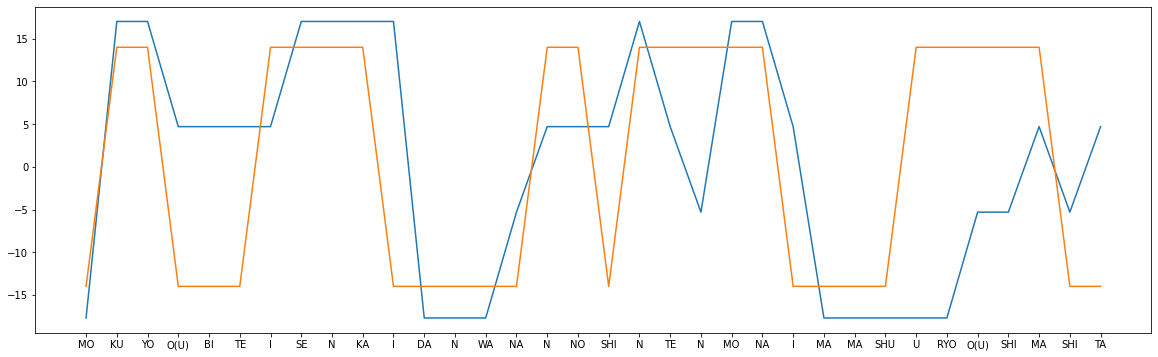

0.4432589562786603


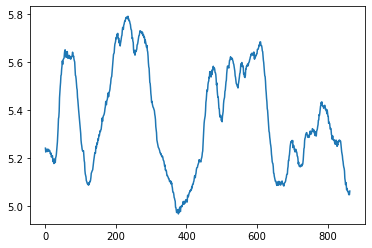

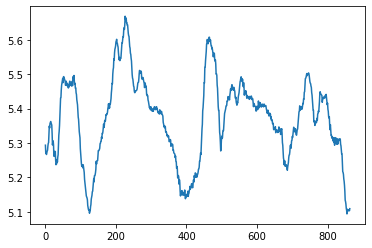

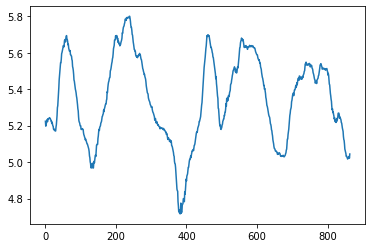

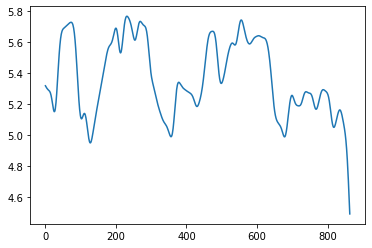

In [73]:
index = 0
valid=False
synthesize(index, valid=valid)
synthesize(index, z0=True, valid=valid)
synthesize(index, valid=valid, lh=True)
IPython.display.display(Audio(gen_waveform(test_loader[index][1], True), rate=fs))

In [74]:
def rmse(A, B) :
    return np.sqrt((np.square(A - B)).mean())

def calc_lf0_rmse(natural, generated, lf0_idx=lf0_start_idx, vuv_idx=vuv_start_idx):
    idx = (natural[:, vuv_idx]).astype(bool)
    return rmse(natural[idx, lf0_idx], generated[idx]) * 1200 / np.log(2)  # unit: [cent]

In [24]:
f0_e = 0
for i, data in tqdm(enumerate(test_loader)):
    with torch.no_grad():
        pred_y = recon(i, z0=True).cpu().numpy().reshape(-1)
        f0_e += calc_lf0_rmse(data[1], pred_y)

250it [00:56,  4.43it/s]


In [25]:
f0_e/250

340.80849452325293

In [83]:
f0_e = 0
savedir = '../../disk/asj_vae/data/basic5000/generated/vqvae'
for i, data in tqdm(enumerate(test_loader)):
    with torch.no_grad():
        pred_y = recon(i,  verbose=False).cpu().numpy().reshape(-1)
        
        y_base = data[1].copy()
        y_base[:, lf0_start_idx] = pred_y
        waveform = gen_waveform(y_base, True, verbose=False)
        wavfile.write(join(savedir, 'BASIC5000_{}{}.wav'.format('0'*(4-len(str(i+1))), i+1)), rate=fs, data=waveform.astype(np.int16))
        f0_e += calc_lf0_rmse(data[1], pred_y)

250it [07:09,  1.72s/it]


In [84]:
f0_e / 250

145.14614010206446

In [85]:
f0_e = 0
savedir = '../../disk/asj_vae/data/basic5000/generated/vqvae_z0'
for i, data in tqdm(enumerate(test_loader)):
    with torch.no_grad():
        pred_y = recon(i, z0=True).cpu().numpy().reshape(-1)
        
        y_base = data[1].copy()
        y_base[:, lf0_start_idx] = pred_y
        wavfile.write(join(savedir, 'BASIC5000_{}{}_z0.wav'.format('0'*(4-len(str(i+1))), i+1)), rate=fs, data=gen_waveform(y_base, True, verbose=False).astype(np.int16))
        f0_e += calc_lf0_rmse(data[1], pred_y)

250it [06:24,  1.54s/it]


In [86]:
f0_e / 250

340.7465390803475

In [ ]:
f0_e = 0
savedir = '../../disk/asj_vae/data/basic5000/generated/vqvae_lh'
for i, data in tqdm(enumerate(test_loader)):
    with torch.no_grad():
        pred_y = recon(i,lh=True).cpu().numpy().reshape(-1)
        
        y_base = data[1].copy()
        y_base[:, lf0_start_idx] = pred_y
        wavfile.write(join(savedir, 'BASIC5000_{}{}_lh.wav'.format('0'*(4-len(str(i+1))), i+1)), rate=fs, data=gen_waveform(y_base, True, verbose=False))
        f0_e += calc_lf0_rmse(data[1], pred_y)

In [71]:
f0_e = 0
for i, data in tqdm(enumerate(test_loader)):
    with torch.no_grad():
        pred_y = recon(i, lh=True).cpu().numpy().reshape(-1)
        f0_e += calc_lf0_rmse(data[1], pred_y)

250it [00:57,  4.32it/s]


In [72]:
f0_e / 250

353.96168724531714